### Imports

In [1]:
import os
import sys
import random

In [2]:
import time

In [3]:
import numpy as np

In [4]:
import torch
from torch.utils.data import Dataset

In [5]:
from torch import nn

In [6]:
import torchvision
import torchvision.transforms as transforms

In [7]:
from torchvision.transforms import InterpolationMode

In [8]:
# our library
from svetlanna import SimulationParameters
from svetlanna.parameters import BoundedParameter

In [9]:
# our library
from svetlanna import Wavefront
from svetlanna import elements
from svetlanna.setup import LinearOpticalSetup
from svetlanna.detector import Detector, DetectorProcessorClf

In [10]:
from svetlanna.transforms import ToWavefront

In [11]:
# datasets of wavefronts
from src.wf_datasets import DatasetOfWavefronts
from src.wf_datasets import IlluminatedApertureDataset

In [12]:
from tqdm import tqdm

In [13]:
import json

In [14]:
from datetime import datetime

In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.style.use('dark_background')
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

# Optical Neural Network

In that example notebook we will make some experiments^ based on a n opticel network architecture proposed in [the article](https://www.science.org/doi/10.1126/science.aat8084).

# 0. Experiment parameters

In [21]:
working_frequency = 0.4 * 1e12 # [Hz]
C_CONST = 299_792_458  # [m / s]

In [17]:
EXP_NUMBER = 1

In [18]:
EXP_CONDITIONS = {
    'wavelength'  : C_CONST / working_frequency,  # [m]
    'layer_size_m': 8 * 1e-2,  # [m] - x and y sizes are equal!
    'layer_nodes' : 100,
    # DATASET
    'digit_resize' : 17,  # the actual digit size after resize (in nodes)
    'ds_apertures': True,  # if dataset is created with diigit-shaped apertures (True) or with direct modulation (False)
        # must be specified if 'ds_apertures' == False, values: 'amp', 'phase' or 'both'
    'ds_modulation': None, 
        # must be specified if 'ds_apertures' == True
    'gauss_waist_radius': 2e-2,  # [m] - gaussian beam for dataset creation
    'distance_to_aperture': 3e-2,  # [m]
    # SETUP
    'propagator': 'AS',  # FreeSpase propagation method: 'AS' or 'fresnel' (also needed for dataset with apertures)
        # diffractive layers
    'n_diff_layers': 5,  # number of diffractive layers
    'diff_layer_max_phase': torch.pi,  # maximal phase for each DiffractiveLayer
    'diff_layer_mask_init': 'const',  # initialization of DiffractiveLayer masks: 'const' or 'random'
    'diff_layers_seeds': 123,  # if 'random': seed to generate seeds to init all masks!
        # free space
    'layers_distance': 3e-2,  # [m], distance between layers
        # apertures
    'add_apertures': True,  # if True - adds square apertures (in the middle) before each diffractive layer
    'apertures_size': (50, 50),  # size of additional apertures in a setup
        # detector
    'detector_zones': 'strips',  # form of a detector zones: 'squares' or 'circles' or 'strips'
    'detector_transpose': True,  # transpose detector or not (makes 'strips' horizontal instead of vertical)
    # TRAINING PROCESS
    'train_bs': 8,
    'val_bs': 20,  # batch sizes
    'train_split_seed': 178,  # seed for a data split on train/validation
    'epochs': 10,
}

In [19]:
today_date = datetime.today().strftime('%d-%m-%Y')

RESULTS_FOLDER = (
    f'models/03_mnist_experiments/{today_date}_experiment_{EXP_NUMBER:02d}'
)

RESULTS_FOLDER

'models/03_mnist_experiments/27-11-2024_experiment_01'

In [20]:
if not os.path.exists(RESULTS_FOLDER):
    os.makedirs(RESULTS_FOLDER)

In [21]:
# save experiment conditions
json.dump(EXP_CONDITIONS, open(f'{RESULTS_FOLDER}/conditions.json', 'w'))

In [22]:
# OR read conditions from file:
# EXP_CONDITIONS = json.load(open(f'{RESULTS_FOLDER}/conditions.json))
# print(EXP_CONDITIONS)

# 1. Simulation parameters

In [22]:
working_wavelength = EXP_CONDITIONS['wavelength']  # [m]
print(f'lambda = {working_wavelength * 1e6:.3f} um')

lambda = 749.481 um


In [23]:
# physical size of each layer (from the article) - (8 x 8) [cm]
x_layer_size_m = EXP_CONDITIONS['layer_size_m']  # [m]
y_layer_size_m = x_layer_size_m

In [24]:
# number of neurons in simulation
x_layer_nodes = EXP_CONDITIONS['layer_nodes']
y_layer_nodes = x_layer_nodes

In [25]:
print(f'Layer size (neurons): {x_layer_nodes} x {y_layer_nodes} = {x_layer_nodes * y_layer_nodes}')

Layer size (neurons): 100 x 100 = 10000


In [26]:
neuron_size = x_layer_size_m / x_layer_nodes  # [m]  increase two times!
print(f'Neuron size = {neuron_size * 1e6:.3f} um')

Neuron size = 800.000 um


In [27]:
# simulation parameters for the rest of the notebook

SIM_PARAMS = SimulationParameters(
    axes={
        'W': torch.linspace(-x_layer_size_m / 2, x_layer_size_m / 2, x_layer_nodes),
        'H': torch.linspace(-y_layer_size_m / 2, y_layer_size_m / 2, y_layer_nodes),
        'wavelength': working_wavelength,  # only one wavelength!
    }
)

# 2. Dataset preparation (Data Engineer)

## 2.1. [MNIST Dataset](https://www.kaggle.com/datasets/hojjatk/mnist-dataset)

In [28]:
# initialize a directory for a dataset
MNIST_DATA_FOLDER = './data'  # folder to store data

### 2.1.1. Train/Test datasets of images

In [29]:
# TRAIN (images)
mnist_train_ds = torchvision.datasets.MNIST(
    root=MNIST_DATA_FOLDER,
    train=True,  # for train dataset
    download=False,
)

In [30]:
# TEST (images)
mnist_test_ds = torchvision.datasets.MNIST(
    root=MNIST_DATA_FOLDER,
    train=False,  # for test dataset
    download=False,
)

In [31]:
print(f'Train data: {len(mnist_train_ds)}')
print(f'Test data : {len(mnist_test_ds)}')

Train data: 60000
Test data : 10000


### 2.1.2. Train/Test datasets of wavefronts

In [32]:
DS_WITH_APERTURES = EXP_CONDITIONS['ds_apertures'] 
# if True we use IlluminatedApertureDataset to create datasets of Wavefronts
# else - DatasetOfWavefronts
DS_WITH_APERTURES

True

In [33]:
# select modulation type for DatasetOfWavefronts if DS_WITH_APERTURES == False
MODULATION_TYPE = EXP_CONDITIONS['ds_modulation']  # 'phase', 'amp', 'amp&phase'

# select method and distance for a FreeSpace in IlluminatedApertureDataset
DS_METHOD = EXP_CONDITIONS['propagator']
DS_DISTANCE = EXP_CONDITIONS['distance_to_aperture']  # [m]

DS_BEAM = Wavefront.gaussian_beam(
    simulation_parameters=SIM_PARAMS,
    waist_radius=EXP_CONDITIONS['gauss_waist_radius'],  # [m]
)

In [34]:
# image resize to match SimulationParameters
resize_y = EXP_CONDITIONS['digit_resize']
resize_x = resize_y  # shape for transforms.Resize

pad_top = int((y_layer_nodes - resize_y) / 2)
pad_bottom = y_layer_nodes - pad_top - resize_y
pad_left = int((x_layer_nodes - resize_x) / 2)
pad_right = x_layer_nodes - pad_left - resize_x  # params for transforms.Pad

In [35]:
# compose all transforms for DatasetOfWavefronts
image_transform_for_ds = transforms.Compose(
  [
      transforms.ToTensor(),
      transforms.Resize(
          size=(resize_y, resize_x),
          interpolation=InterpolationMode.NEAREST,
      ),
      transforms.Pad(
          padding=(
              pad_left,  # left padding
              pad_top,  # top padding
              pad_right,  # right padding
              pad_bottom  # bottom padding
          ),
          fill=0,
      ),  # padding to match sizes!
      ToWavefront(modulation_type=MODULATION_TYPE)  # <- select modulation type!!!
  ]  
)

# compose all transforms for IlluminatedApertureDataset
image_to_aperture = transforms.Compose(
  [
      transforms.ToTensor(),
      transforms.Resize(
          size=(resize_y, resize_x),
          interpolation=InterpolationMode.NEAREST,
      ),
      transforms.Pad(
          padding=(
              pad_left,  # left padding
              pad_top,  # top padding
              pad_right,  # right padding
              pad_bottom  # bottom padding
          ),
          fill=0,
      ),  # padding to match sizes!
  ]  
)

In [36]:
# TRAIN dataset of WAVEFRONTS
if not DS_WITH_APERTURES:
    mnist_wf_train_ds = DatasetOfWavefronts(
        init_ds=mnist_train_ds,  # dataset of images
        transformations=image_transform_for_ds,  # image transformation
        sim_params=SIM_PARAMS,  # simulation parameters
    )
else:
    mnist_wf_train_ds = IlluminatedApertureDataset(
        init_ds=mnist_train_ds,  # dataset of images
        transformations=image_to_aperture,  # image transformation
        sim_params=SIM_PARAMS,  # simulation parameters
        beam_field=DS_BEAM,
        distance=DS_DISTANCE,
        method=DS_METHOD,
    )

In [37]:
# TEST dataset of WAVEFRONTS
if not DS_WITH_APERTURES:
    mnist_wf_test_ds = DatasetOfWavefronts(
        init_ds=mnist_test_ds,  # dataset of images
        transformations=image_transform_for_ds,  # image transformation
        sim_params=SIM_PARAMS,  # simulation parameters
    )
else:
    mnist_wf_test_ds = IlluminatedApertureDataset(
        init_ds=mnist_test_ds,  # dataset of images
        transformations=image_to_aperture,  # image transformation
        sim_params=SIM_PARAMS,  # simulation parameters
        beam_field=DS_BEAM,
        distance=DS_DISTANCE,
        method=DS_METHOD,
    )

In [38]:
print(f'Train data: {len(mnist_wf_train_ds)}')
print(f'Test data : {len(mnist_wf_test_ds)}')

Train data: 60000
Test data : 10000


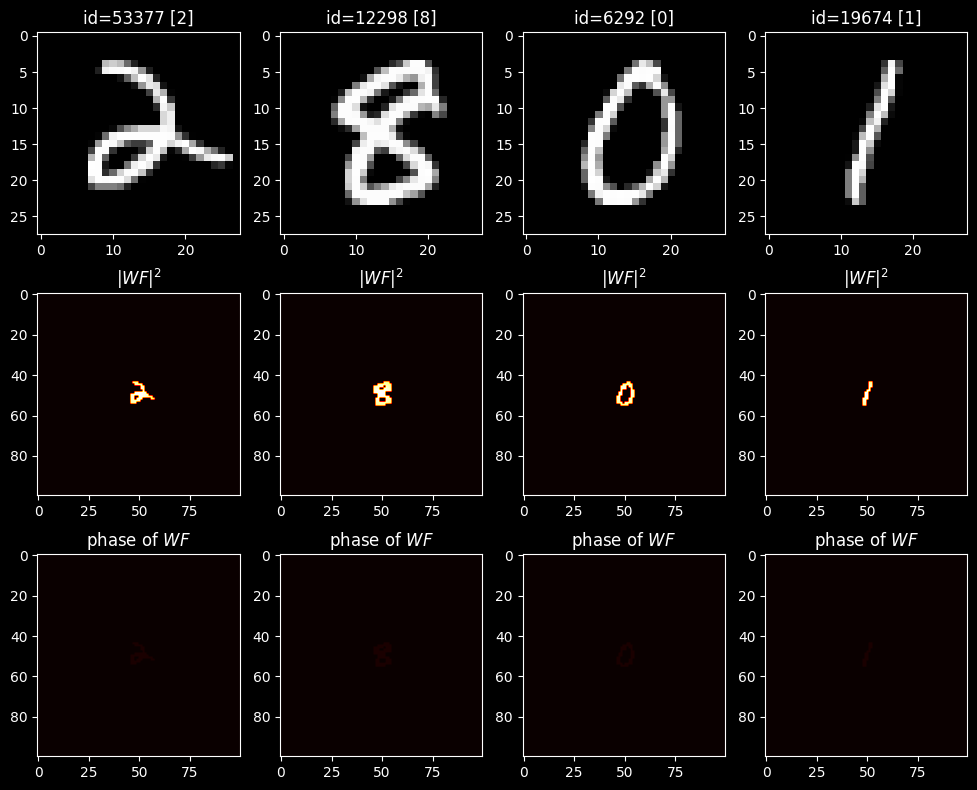

In [39]:
# plot several EXAMPLES from TRAIN dataset
n_examples= 4  # number of examples to plot
# choosing indecies of images (from train) to plot
random.seed(78)
train_examples_ids = random.sample(range(len(mnist_train_ds)), n_examples)

all_examples_wavefronts = []
cmap = 'hot'

n_lines = 3
fig, axs = plt.subplots(n_lines, n_examples, figsize=(n_examples * 3, n_lines * 3.2))
for ind_ex, ind_train in enumerate(train_examples_ids):
    image, label = mnist_train_ds[ind_train]
    
    axs[0][ind_ex].set_title(f'id={ind_train} [{label}]')
    axs[0][ind_ex].imshow(image, cmap='gray')

    wavefront, wf_label = mnist_wf_train_ds[ind_train]
    assert isinstance(wavefront, Wavefront)

    all_examples_wavefronts.append(wavefront)

    axs[1][ind_ex].set_title(f'$|WF|^2$')
    # here we can plot intensity for a wavefront
    axs[1][ind_ex].imshow(
        wavefront.intensity[0], cmap=cmap,
        vmin=0, vmax=1
    )
    
    axs[2][ind_ex].set_title(f'phase of $WF$')
    axs[2][ind_ex].imshow(
        wavefront.phase[0], cmap=cmap,
        vmin=0, vmax= 2 * torch.pi
    )

plt.show()

# 3. Optical network

In [40]:
NUM_OF_DIFF_LAYERS = EXP_CONDITIONS['n_diff_layers']  # number of diffractive layers
FREE_SPACE_DISTANCE = EXP_CONDITIONS['layers_distance']  # [m]

## 3.1. Architecture

### 3.1.1. List of Elements

> To help with the 3D-printing and fabrication of the $D^2NN$ design, a sigmoid function was used to limit the phase value of each neuron to $0-2π$ and $0-π$, for imaging and classifier networks, respectively.

In [41]:
MAX_PHASE = EXP_CONDITIONS['diff_layer_max_phase']

In [42]:
from src.for_setup import get_const_free_space, get_random_diffractive_layer
from torch.nn import functional

Function to construct a list of elements:

In [43]:
# WE WILL ADD APERTURES BEFORE EACH DIFFRACTIVE LAYER OF THE SIZE:
ADD_APERTURES = EXP_CONDITIONS['add_apertures']
APERTURE_SZ = EXP_CONDITIONS['apertures_size']

In [44]:
def get_elements_list(
    num_layers,
    simulation_parameters: SimulationParameters,
    freespace_method,
    masks_seeds,
    apertures=False,
    aperture_size=(100, 100)
):
    """
    Composes a list of elements for setup.
        Optical system: FS|DL|FS|...|FS|DL|FS|Detector
    ...

    Parameters
    ----------
    num_layers : int
        Number of layers in the system.
    simulation_parameters : SimulationParameters()
        A simulation parameters for a task.
    freespace_method : str
        Propagation method for free spaces in a setup.
    masks_seeds : torch.Tensor()
        Torch tensor of random seeds to generate masks for diffractive layers.

    Returns
    -------
    elements_list : list(Element)
        List of Elements for an optical setup.
    """
    elements_list = []  # list of elements

    if apertures:  # equal masks for all apertures (select a part in the middle)
        aperture_mask = torch.ones(size=aperture_size)

        y_nodes, x_nodes = simulation_parameters.axes_size(axs=('H', 'W'))
        y_mask, x_mask = aperture_mask.size()
        pad_top = int((y_nodes - y_mask) / 2)
        pad_bottom = y_nodes - pad_top - y_mask
        pad_left = int((x_nodes - x_mask) / 2)
        pad_right = x_nodes - pad_left - x_mask  # params for transforms.Pad
        
        # padding transform to match aperture size with simulation parameters     
        aperture_mask = functional.pad(
            input=aperture_mask,
            pad=(pad_left, pad_right, pad_top, pad_bottom),
            mode='constant',
            value=0
        )

    # compose architecture
    for ind_layer in range(num_layers):
        if ind_layer == 0:
            # first FreeSpace layer before first DiffractiveLayer
            elements_list.append(
                get_const_free_space(
                    simulation_parameters,  # simulation parameters for the notebook
                    FREE_SPACE_DISTANCE,  # in [m]
                    freespace_method=freespace_method,
                )
            )
    
        # add aperture before each diffractive layer
        if apertures:
            elements_list.append(
                elements.Aperture(
                    simulation_parameters=simulation_parameters,
                    mask=nn.Parameter(aperture_mask, requires_grad=False)
                )
            )
            
        # add DiffractiveLayer
        elements_list.append(
            get_random_diffractive_layer(
                simulation_parameters,  # simulation parameters for the notebook
                mask_seed=masks_seeds[ind_layer].item(),
                max_phase=MAX_PHASE
            )
        )
        # add FreeSpace
        elements_list.append(
            get_const_free_space(
                simulation_parameters,  # simulation parameters for the notebook
                FREE_SPACE_DISTANCE,  # in [m]
                freespace_method=freespace_method,
            )
        )
    
    # add Detector in the end of the system!
    elements_list.append(
        Detector(
            simulation_parameters=simulation_parameters,
            func='intensity'  # detector that returns intensity
        )
    )

    return elements_list

Constants for a setup initialization:

In [45]:
FREESPACE_METHOD = EXP_CONDITIONS['propagator'] # TODO: 'AS' returns nan's?

if EXP_CONDITIONS['diff_layer_mask_init'] == 'random':
    MASKS_SEEDS = torch.randint(
        low=0, high=100,
        size=(NUM_OF_DIFF_LAYERS,),
        generator=torch.Generator().manual_seed(EXP_CONDITIONS['diff_layers_seeds'])
        # to generate the same set of initial masks
    )  # for the same random generation

if EXP_CONDITIONS['diff_layer_mask_init'] == 'const':
    MASKS_SEEDS = torch.ones(size=(NUM_OF_DIFF_LAYERS,)) * torch.pi / 2  # constant masks init

MASKS_SEEDS

tensor([1.5708, 1.5708, 1.5708, 1.5708, 1.5708])

### 3.1.2. Compose `LinearOpticalSetup`

In [46]:
def get_setup(
    simulation_parameters, 
    num_layers, 
    apertures=False, 
    aperture_size=(100,100)
):
    """
    Returns an optical setup. Recreates all elements.
    """
    elements_list = get_elements_list(
        num_layers,
        simulation_parameters,
        FREESPACE_METHOD,
        MASKS_SEEDS,
        apertures=apertures,
        aperture_size=aperture_size
    )  # recreate a list of elements

    return LinearOpticalSetup(elements=elements_list)

In [47]:
lin_optical_setup = get_setup(
    SIM_PARAMS,
    NUM_OF_DIFF_LAYERS,
    apertures=ADD_APERTURES, 
    aperture_size=APERTURE_SZ
)
# Comment: Lin - a surname of the first author of the article

In [48]:
lin_optical_setup.net

Sequential(
  (0): FreeSpace()
  (1): DiffractiveLayer()
  (2): FreeSpace()
  (3): DiffractiveLayer()
  (4): FreeSpace()
  (5): DiffractiveLayer()
  (6): FreeSpace()
  (7): DiffractiveLayer()
  (8): FreeSpace()
  (9): DiffractiveLayer()
  (10): FreeSpace()
  (11): Detector()
)

#### Example of a wavefrnt propagation

In [49]:
example_wf = mnist_wf_train_ds[128][0]

In [50]:
mnist_wf_train_ds[128][1]

1

In [51]:
setup_scheme, wavefronts = lin_optical_setup.stepwise_forward(example_wf)

-(0)-> [1. FreeSpace] -(1)-> [2. DiffractiveLayer] -(2)-> [3. FreeSpace] -(3)-> [4. DiffractiveLayer] -(4)-> [5. FreeSpace] -(5)-> [6. DiffractiveLayer] -(6)-> [7. FreeSpace] -(7)-> [8. DiffractiveLayer] -(8)-> [9. FreeSpace] -(9)-> [10. DiffractiveLayer] -(10)-> [11. FreeSpace] -(11)-> [12. Detector] -(12)->


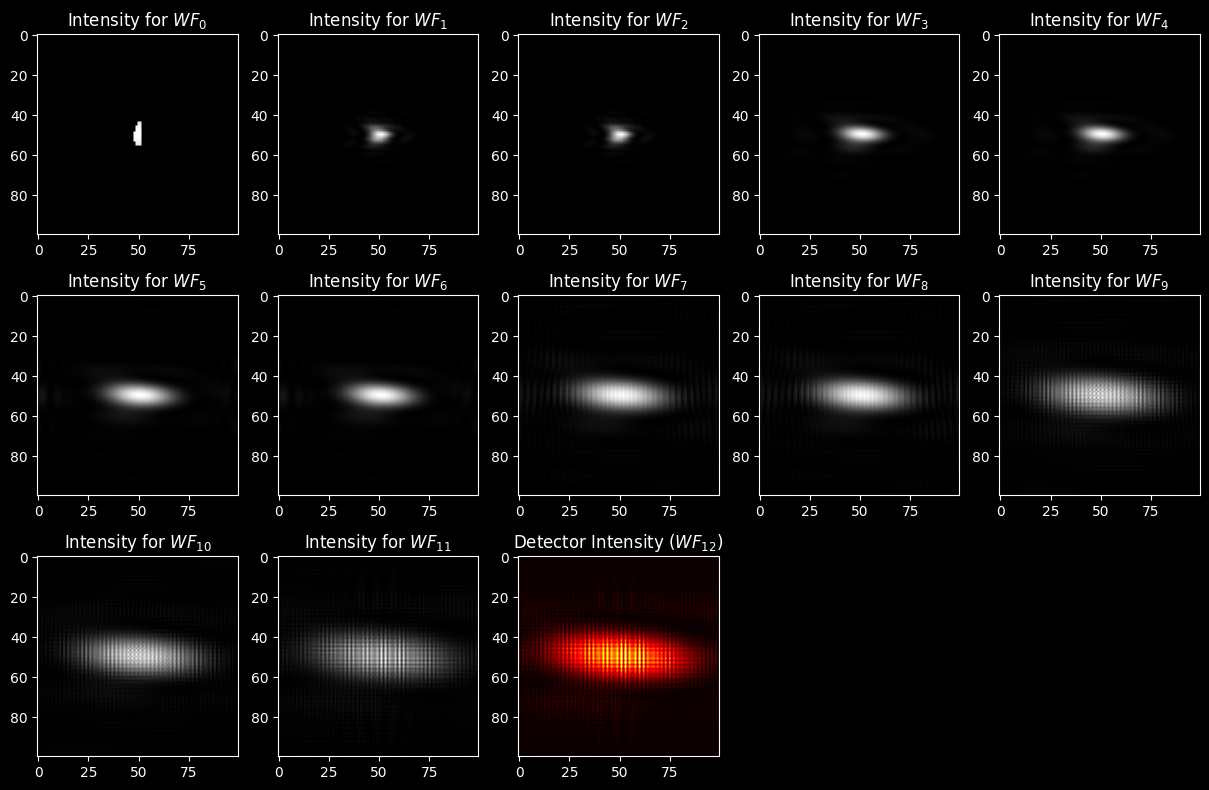

In [52]:
print(setup_scheme)  # prints propagation scheme

n_cols = 5  # number of columns to plot all wavefronts during propagation
n_rows = (len(lin_optical_setup.net) // n_cols) + 1

to_plot = 'amp'  # <--- chose what to plot
cmap = 'grey'  # choose colormaps
detector_cmap = 'hot'

# create a figure with subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3.2))

# turn off unecessary axes
for ind_row in range(n_rows):
    for ind_col in range(n_cols):
        ax_this = axs[ind_row][ind_col]
        if ind_row * n_cols + ind_col >= len(wavefronts):
            ax_this.axis('off')

# plot wavefronts
for ind_wf, wavefront in enumerate(wavefronts):
    ax_this = axs[ind_wf // n_cols][ind_wf % n_cols]

    if to_plot == 'phase':
        # plot angle for each wavefront, because intensities pictures are indistinguishable from each other
        if ind_wf < len(wavefronts) - 1:
            ax_this.set_title('Phase for $WF_{' + f'{ind_wf}' + '}$')
            ax_this.imshow(
                wavefront[0].phase.detach().numpy(), cmap=cmap,
                vmin=0, vmax=2 * torch.pi
            )
        else:  # (not a wavefront!)
            ax_this.set_title('Detector phase ($WF_{' + f'{ind_wf}' + '})$')
            # Detector has no phase!

    if to_plot == 'amp':
        # plot angle for each wavefront, because intensities pictures are indistinguishable from each other
        if ind_wf < len(wavefronts) - 1:
            ax_this.set_title('Intensity for $WF_{' + f'{ind_wf}' + '}$')
            ax_this.imshow(
                wavefront[0].intensity.detach().numpy(), cmap=cmap,
                # vmin=0, vmax=max_intensity  # uncomment to make the same limits
            )
        else:  # Detector output (not a wavefront!)
            ax_this.set_title('Detector Intensity ($WF_{' + f'{ind_wf}' + '})$')
            ax_this.imshow(
                wavefront[0].detach().numpy(), cmap=detector_cmap,
                # vmin=0, vmax=max_intensity  # uncomment to make the same limits
            )
            
    # Comment: Detector output is Tensor! It has no methods of Wavefront (like .phase or .intensity)!

plt.show()

### 3.1.3 Detector processor

In [53]:
number_of_classes = 10

In [54]:
if ADD_APERTURES or APERTURE_SZ:
    y_detector_nodes, x_detector_nodes = APERTURE_SZ
else:
    y_detector_nodes, x_detector_nodes = SIM_PARAMS.axes_size(axs=('H', 'W'))

In [55]:
ADD_APERTURES

False

#### Detector mask (square zones)

In [56]:
# size of each segment
x_segment_nodes = int(x_detector_nodes / 9)
y_segment_nodes = int(y_detector_nodes / 9)  # each segment of size = (y_segment_nodes, x_segment_nodes)

In [57]:
# coordinates of segments left upper corners (in nodes)
segments_corners = {}

for ind, label in enumerate(range(3)):
    segments_corners[label] = (
        y_detector_nodes // 4 - y_segment_nodes // 2,
        2 * x_segment_nodes + ind * (2 * x_segment_nodes)
    )

for ind, label in enumerate(range(3, 7)):
    segments_corners[label] = (
        y_detector_nodes // 2 - y_segment_nodes // 2,
        x_segment_nodes + ind * (2 * x_segment_nodes)
    )

for ind, label in enumerate(range(7, 10)):
    segments_corners[label] = (
        3 * y_detector_nodes // 4 - y_segment_nodes // 2,
        2 * x_segment_nodes + ind * (2 * x_segment_nodes)
    )

In [58]:
# create a mask for detector
detector_mask = torch.ones(
    size=(y_detector_nodes, x_detector_nodes),
) * (-1)

for label in segments_corners.keys():
    y_node, x_node = segments_corners[label]
    detector_mask[y_node:y_node + y_segment_nodes, x_node:x_node + x_segment_nodes] = label

# ADD PADDING IF APERTURES USED!
if ADD_APERTURES or APERTURE_SZ:
    y_nodes, x_nodes = SIM_PARAMS.axes_size(axs=('H', 'W'))
    y_mask, x_mask = detector_mask.size()
    pad_top = int((y_nodes - y_mask) / 2)
    pad_bottom = y_nodes - pad_top - y_mask
    pad_left = int((x_nodes - x_mask) / 2)
    pad_right = x_nodes - pad_left - x_mask  # params for transforms.Pad
    
    # padding transform to match aperture size with simulation parameters     
    detector_mask = functional.pad(
        input=detector_mask,
        pad=(pad_left, pad_right, pad_top, pad_bottom),
        mode='constant',
        value=-1
    )

assert detector_mask.size() == SIM_PARAMS.axes_size(axs=('H', 'W'))

In [59]:
detector_squares_mask = detector_mask

#### Detector mask (circular zones)

In [60]:
y_detector_nodes, x_detector_nodes = SIM_PARAMS.axes_size(axs=('H', 'W'))

In [61]:
if ADD_APERTURES or APERTURE_SZ:
    max_radii = x_layer_size_m / 2 * APERTURE_SZ[0] / x_layer_nodes  # in [m]
else:
    max_radii = x_layer_size_m / 2  # in [m]

circles_radiuses = torch.linspace(max_radii / number_of_classes, max_radii, number_of_classes)

In [62]:
circles_radiuses

tensor([0.0020, 0.0040, 0.0060, 0.0080, 0.0100, 0.0120, 0.0140, 0.0160, 0.0180,
        0.0200])

In [63]:
detector_circles_mask = torch.ones(
    size=(y_detector_nodes, x_detector_nodes),
) * (-1)

In [64]:
grid_x, grid_y = torch.meshgrid(SIM_PARAMS.axes['W'], SIM_PARAMS.axes['H'], indexing='xy')
distances_mask = torch.sqrt(grid_x ** 2 + grid_y ** 2)

# create a mask for detector
for ind, radius in enumerate(reversed(circles_radiuses)):
    class_num = number_of_classes - 1 - ind
    detector_circles_mask[distances_mask <= radius] = class_num

detector_circles_mask[distances_mask > circles_radiuses[-1]] = -1

#### Detector processor

In [65]:
CIRCLES_ZONES = EXP_CONDITIONS['detector_zones'] == 'circles'
CIRCLES_ZONES

False

In [66]:
if EXP_CONDITIONS['detector_zones'] == 'circles':
    selected_mask = detector_circles_mask
    print('circles selected!')

if EXP_CONDITIONS['detector_zones'] == 'squares':
    selected_mask = detector_squares_mask
    print('squares selected!')

if EXP_CONDITIONS['detector_zones'] == 'strips':
    selected_mask = None
    print('strips selected!')

squares selected!


In [67]:
detector_processor = DetectorProcessorClf(
    num_classes=number_of_classes,
    simulation_parameters=SIM_PARAMS,
    segmented_detector=selected_mask,  # choose a mask!
    segments_zone_size=APERTURE_SZ
)

In [68]:
if 'detector_transpose' in EXP_CONDITIONS.keys():
    if EXP_CONDITIONS['detector_transpose']:
        detector_processor.segmented_detector = detector_processor.segmented_detector.T

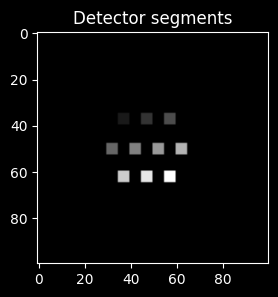

In [69]:
fig, ax0 = plt.subplots(1, 1, figsize=(3, 3))

ax0.set_title(f'Detector segments')
ax0.imshow(detector_processor.segmented_detector, cmap='grey')

plt.show()

#### Zones visualization. To draw zones on a detector...

In [70]:
ZONES_HIGHLIGHT_COLOR = 'w'
selected_detector_mask = detector_processor.segmented_detector.clone().detach()

In [71]:
def get_zones_patches(detector_mask):
    """
    Returns a list of patches to draw zones in final visualisation
    """
    zones_patches = []
    
    if EXP_CONDITIONS['detector_zones'] == 'circles':
        for ind_class in range(number_of_classes):
            # use `circles_radiuses`, `x_layer_size_m`, `x_layer_nodes`
            rad_this = (circles_radiuses[ind_class] / x_layer_size_m * x_layer_nodes)
                    
            zone_circ = patches.Circle(
                (x_layer_nodes / 2, y_layer_nodes / 2), 
                rad_this, 
                linewidth=0.5, 
                edgecolor=ZONES_HIGHLIGHT_COLOR,
                facecolor='none'
            )
            
            zones_patches.append(zone_circ)
    else:
        delta = 0.5
        
        for ind_class in range(number_of_classes):
            idx_y, idx_x = (detector_mask == ind_class).nonzero(as_tuple=True)
            
            zone_rect = patches.Rectangle(
                (idx_x[0] - delta, idx_y[0] - delta), 
                idx_x[-1] - idx_x[0] + 2 * delta, idx_y[-1] - idx_y[0] + 2 * delta, 
                linewidth=0.5, 
                edgecolor=ZONES_HIGHLIGHT_COLOR,
                facecolor='none'
            )
            
            zones_patches.append(zone_rect)

    return zones_patches

# 4. Training of the network

Variables at the moment
- `lin_optical_setup` : `LinearOpticalSetup` – a linear optical network composed of Elements
- `detector_processor` : `DetectorProcessorClf` – this layer process an image from the detector and calculates probabilities of belonging to classes.

In [72]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# if DEVICE == torch.device('cpu'):
#     DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
    
DEVICE

device(type='cpu')

## 4.1. Prepare some stuff for training

### 4.1.1. `DataLoader`'s

In [73]:
train_bs = EXP_CONDITIONS['train_bs']  # a batch size for training set
val_bs = EXP_CONDITIONS['val_bs']

> Forthis task, phase-only transmission masks weredesigned by training a five-layer $D^2 NN$ with $55000$ images ($5000$ validation images) from theMNIST (Modified National Institute of Stan-dards and Technology) handwritten digit data-base.

In [74]:
# mnist_wf_train_ds
train_wf_ds, val_wf_ds = torch.utils.data.random_split(
    dataset=mnist_wf_train_ds,
    lengths=[55000, 5000],  # sizes from the article
    generator=torch.Generator().manual_seed(EXP_CONDITIONS['train_split_seed'])  # for reproducibility
)

In [75]:
train_wf_loader = torch.utils.data.DataLoader(
    train_wf_ds,
    batch_size=train_bs,
    shuffle=True,
    # num_workers=2,
    drop_last=False,
)

val_wf_loader = torch.utils.data.DataLoader(
    val_wf_ds,
    batch_size=val_bs,
    shuffle=False,
    # num_workers=2,
    drop_last=False,
)

### 4.1.2. Optimizer and loss function

Info from [a supplementary material](https://www.science.org/doi/suppl/10.1126/science.aat8084/suppl_file/aat8084-lin-sm-rev-3.pdf) for MNIST classification:

> We used the stochastic gradient descent algorithm, Adam, to back-propagate the errors and update the
layers of the network to minimize the loss function.

In [76]:
optimizer_clf = torch.optim.Adam(
    params=lin_optical_setup.net.parameters()  # NETWORK PARAMETERS!
)

In [77]:
loss_func_clf = nn.CrossEntropyLoss()
loss_func_name = 'CE loss'

### 4.1.3. Training and evaluation loops

In [78]:
from src.clf_loops import onn_train_clf, onn_validate_clf

## 4.2. Training of the optical network

### 4.2.1. Before training

#### Diffractive layers masks

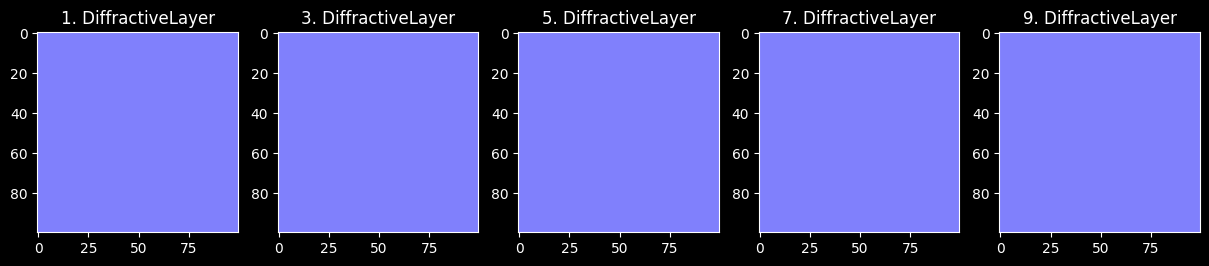

In [79]:
n_cols = NUM_OF_DIFF_LAYERS  # number of columns for DiffractiveLayer's masks visualization
n_rows = 1

lin_architecture_elements_list = get_elements_list(
    NUM_OF_DIFF_LAYERS,
    SIM_PARAMS,
    FREESPACE_METHOD,
    MASKS_SEEDS,
    apertures=ADD_APERTURES,
    aperture_size=APERTURE_SZ
)

cmap = 'gist_stern'

# plot wavefronts phase
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3.2))
ind_diff_layer = 0

for ind_layer, layer in enumerate(lin_architecture_elements_list):
    if isinstance(layer, elements.DiffractiveLayer):  # plot masks for Diffractive layers
        if n_rows > 1:
            ax_this = axs[ind_diff_layer // n_cols][ind_diff_layer % n_cols]
        else:
            ax_this = axs[ind_diff_layer % n_cols]

        ax_this.set_title(f'{ind_layer}. DiffractiveLayer')

        ax_this.imshow(
            layer.mask.detach().numpy(), cmap=cmap,
            vmin=0, vmax=MAX_PHASE
        )
        ind_diff_layer += 1

plt.show()

#### Metrics for test dataset

In [80]:
lin_optical_setup = get_setup(
    SIM_PARAMS.to(DEVICE),
    NUM_OF_DIFF_LAYERS,
    apertures=ADD_APERTURES, 
    aperture_size=APERTURE_SZ
)

In [81]:
lin_optical_setup.net = lin_optical_setup.net.to(DEVICE)

SIM_PARAMS = SIM_PARAMS.to(DEVICE)  # IMPORTANT!
detector_processor = detector_processor.to(DEVICE)

In [82]:
test_wf_loader = torch.utils.data.DataLoader(
    mnist_wf_test_ds,
    batch_size=10,
    shuffle=False,
    # num_workers=2,
    drop_last=False,
)  # data loader for a test MNIST data

In [83]:
test_losses_0, _, test_accuracy_0 = onn_validate_clf(
    lin_optical_setup.net,  # optical network composed in 3.
    test_wf_loader,  # dataloader of training set
    detector_processor,  # detector processor
    loss_func_clf,
    device=DEVICE,
    show_process=True,
)  # evaluate the model

print(
    'Results before training on TEST set:\n' + 
    f'\t{loss_func_name} : {np.mean(test_losses_0):.6f}\n' +
    f'\tAccuracy : {(test_accuracy_0*100):>0.1f} %'
)

validation: 100%|████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 95.06it/s]

Results before training on TEST set:
	CE loss : 2.314514
	Accuracy : 8.9 %


### 4.2.2. Training

In [84]:
n_epochs = EXP_CONDITIONS['epochs']
print_each = 1  # print each n'th epoch info

In [85]:
scheduler = None  # sheduler for a lr tuning during training 

In [86]:
# Recreate a system to restart training!

lin_optical_setup = get_setup(
    SIM_PARAMS.to(DEVICE),
    NUM_OF_DIFF_LAYERS,
    apertures=ADD_APERTURES, 
    aperture_size=APERTURE_SZ
)

# Linc optimizer to a recreated net!
optimizer_clf = torch.optim.Adam(
    params=lin_optical_setup.net.parameters()  # NETWORK PARAMETERS!
)

In [87]:
lin_optical_setup.net

Sequential(
  (0): FreeSpace()
  (1): DiffractiveLayer()
  (2): FreeSpace()
  (3): DiffractiveLayer()
  (4): FreeSpace()
  (5): DiffractiveLayer()
  (6): FreeSpace()
  (7): DiffractiveLayer()
  (8): FreeSpace()
  (9): DiffractiveLayer()
  (10): FreeSpace()
  (11): Detector()
)

In [88]:
lin_optical_setup.net = lin_optical_setup.net.to(DEVICE)

SIM_PARAMS = SIM_PARAMS.to(DEVICE)  # IMPORTANT!
detector_processor = detector_processor.to(DEVICE)  # detector processor also must be on device!

In [89]:
train_epochs_losses = []
val_epochs_losses = []  # to store losses of each epoch

train_epochs_acc = []
val_epochs_acc = []  # to store accuracies

torch.manual_seed(98)  # for reproducability?

for epoch in range(n_epochs):
    if (epoch == 0) or ((epoch + 1) % print_each == 0):
        print(f'Epoch #{epoch + 1}: ', end='')
        show_progress = True
    else:
        show_progress = False

    # TRAIN
    start_train_time = time.time()  # start time of the epoch (train)
    train_losses, _, train_accuracy = onn_train_clf(
        lin_optical_setup.net,  # optical network composed in 3.
        train_wf_loader,  # dataloader of training set
        detector_processor,  # detector processor
        loss_func_clf,
        optimizer_clf,
        device=DEVICE,
        show_process=show_progress,
    )  # train the model
    mean_train_loss = np.mean(train_losses)
    
    if (epoch == 0) or ((epoch + 1) % print_each == 0):  # train info
        print('Training results')
        print(f'\t{loss_func_name} : {mean_train_loss:.6f}')
        print(f'\tAccuracy : {(train_accuracy*100):>0.1f} %')
        print(f'\t------------   {time.time() - start_train_time:.2f} s')

    # VALIDATION
    start_val_time = time.time()  # start time of the epoch (validation)
    val_losses, _, val_accuracy = onn_validate_clf(
        lin_optical_setup.net,  # optical network composed in 3.
        val_wf_loader,  # dataloader of validation set
        detector_processor,  # detector processor
        loss_func_clf,
        device=DEVICE,
        show_process=show_progress,
    )  # evaluate the model
    mean_val_loss = np.mean(val_losses)
    
    if (epoch == 0) or ((epoch + 1) % print_each == 0):  # validation info
        print('Validation results')
        print(f'\t{loss_func_name} : {mean_val_loss:.6f}')
        print(f'\tAccuracy : {(val_accuracy*100):>0.1f} %')
        print(f'\t------------   {time.time() - start_val_time:.2f} s')
            
    if scheduler:
        scheduler.step(mean_val_loss)

    # save losses
    train_epochs_losses.append(mean_train_loss)
    val_epochs_losses.append(mean_val_loss)
    # seve accuracies
    train_epochs_acc.append(train_accuracy)
    val_epochs_acc.append(val_accuracy)

Epoch #1: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [02:26<00:00, 46.84it/s]


Training results
	CE loss : 1.881347
	Accuracy : 81.0 %
	------------   146.77 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [00:10<00:00, 23.55it/s]


Validation results
	CE loss : 1.847347
	Accuracy : 83.1 %
	------------   10.62 s
Epoch #2: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [02:50<00:00, 40.33it/s]


Training results
	CE loss : 1.838472
	Accuracy : 83.7 %
	------------   170.48 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [00:07<00:00, 34.81it/s]


Validation results
	CE loss : 1.839752
	Accuracy : 83.5 %
	------------   7.19 s
Epoch #3: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [02:25<00:00, 47.22it/s]


Training results
	CE loss : 1.832354
	Accuracy : 83.8 %
	------------   145.59 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [00:07<00:00, 34.34it/s]


Validation results
	CE loss : 1.833770
	Accuracy : 83.7 %
	------------   7.28 s
Epoch #4: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [02:25<00:00, 47.24it/s]


Training results
	CE loss : 1.829134
	Accuracy : 83.8 %
	------------   145.53 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 31.25it/s]


Validation results
	CE loss : 1.831335
	Accuracy : 83.7 %
	------------   8.00 s
Epoch #5: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [02:40<00:00, 42.84it/s]


Training results
	CE loss : 1.827254
	Accuracy : 83.7 %
	------------   160.47 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [00:07<00:00, 31.86it/s]


Validation results
	CE loss : 1.830219
	Accuracy : 83.3 %
	------------   7.85 s
Epoch #6: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [02:43<00:00, 42.03it/s]


Training results
	CE loss : 1.825877
	Accuracy : 83.8 %
	------------   163.58 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [00:07<00:00, 33.25it/s]


Validation results
	CE loss : 1.830000
	Accuracy : 83.7 %
	------------   7.52 s
Epoch #7: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [02:33<00:00, 44.78it/s]


Training results
	CE loss : 1.824987
	Accuracy : 83.8 %
	------------   153.52 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [00:07<00:00, 31.32it/s]


Validation results
	CE loss : 1.826708
	Accuracy : 83.2 %
	------------   7.99 s
Epoch #8: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [02:32<00:00, 45.01it/s]


Training results
	CE loss : 1.824067
	Accuracy : 83.9 %
	------------   152.74 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [00:07<00:00, 32.81it/s]


Validation results
	CE loss : 1.825668
	Accuracy : 83.4 %
	------------   7.62 s
Epoch #9: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [02:35<00:00, 44.07it/s]


Training results
	CE loss : 1.823514
	Accuracy : 83.8 %
	------------   156.00 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [00:07<00:00, 31.47it/s]


Validation results
	CE loss : 1.826061
	Accuracy : 84.0 %
	------------   7.95 s
Epoch #10: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [02:36<00:00, 43.81it/s]


Training results
	CE loss : 1.822940
	Accuracy : 83.9 %
	------------   156.93 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 30.11it/s]


Validation results
	CE loss : 1.826517
	Accuracy : 83.3 %
	------------   8.31 s


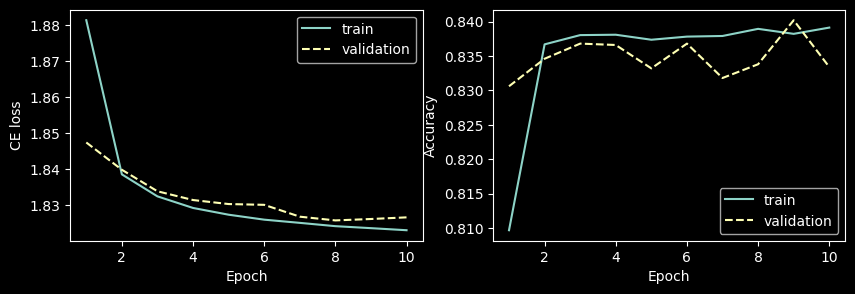

In [92]:
# learning curve
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].plot(range(1, n_epochs + 1), train_epochs_losses, label='train')
axs[0].plot(range(1, n_epochs + 1), val_epochs_losses, linestyle='dashed', label='validation')

axs[1].plot(range(1, n_epochs + 1), train_epochs_acc, label='train')
axs[1].plot(range(1, n_epochs + 1), val_epochs_acc, linestyle='dashed', label='validation')

axs[0].set_ylabel(loss_func_name)
axs[0].set_xlabel('Epoch')
axs[0].legend()

axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend()

plt.show()

In [93]:
# array with all losses
# TODO: make with PANDAS?
all_lasses_header = ','.join([
    f'{loss_func_name.split()[0]}_train', f'{loss_func_name.split()[0]}_val',
    'accuracy_train', 'accuracy_val'
])
all_losses_array = np.array(
    [train_epochs_losses, val_epochs_losses, train_epochs_acc, val_epochs_acc]
).T

### Saving

In [94]:
RESULTS_FOLDER

'models/03_mnist_experiments/22-11-2024_experiment_02'

In [95]:
if not os.path.exists(RESULTS_FOLDER):
    os.makedirs(RESULTS_FOLDER)

In [96]:
# filepath to save the model
model_filepath = f'{RESULTS_FOLDER}/optical_setup_net.pth'
# filepath to save losses
losses_filepath = f'{RESULTS_FOLDER}/training_curves.csv'

In [97]:
# saving model
torch.save(lin_optical_setup.net.state_dict(), model_filepath)

In [98]:
# saving losses
np.savetxt(
    losses_filepath, all_losses_array,
    delimiter=',', header=all_lasses_header, comments=""
)

### 4.2.3. Trained masks

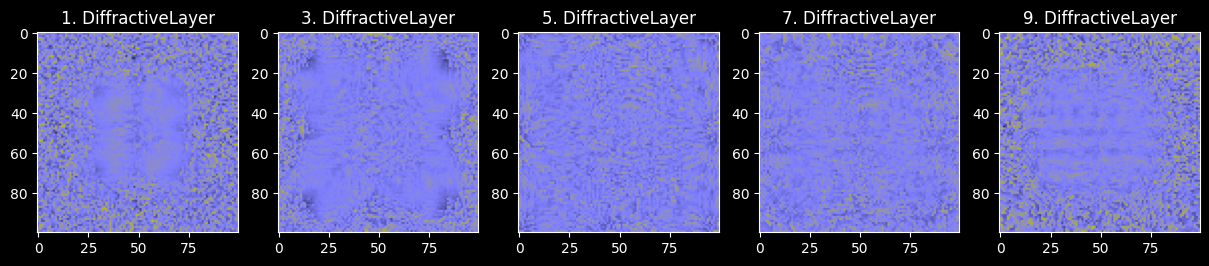

In [99]:
n_cols = NUM_OF_DIFF_LAYERS  # number of columns for DiffractiveLayer's masks visualization
n_rows = 1

# plot wavefronts phase
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3.2))
ind_diff_layer = 0

cmap = 'gist_stern'

for ind_layer, layer in enumerate(lin_optical_setup.net):
    if isinstance(layer, elements.DiffractiveLayer):  # plot masks for Diffractive layers
        if n_rows > 1:
            ax_this = axs[ind_diff_layer // n_cols][ind_diff_layer % n_cols]
        else:
            ax_this = axs[ind_diff_layer % n_cols]

        ax_this.set_title(f'{ind_layer}. DiffractiveLayer')

        trained_mask = layer.mask.detach()

        # mask_seed = MASKS_SEEDS[ind_diff_layer].item()
        # random_mask = torch.rand(
        #     size=(sim_params.y_nodes, sim_params.x_nodes),
        #     generator=torch.Generator().manual_seed(mask_seed)
        # ) * (MAX_PHASE)
        
        ax_this.imshow(         
            trained_mask, cmap=cmap,
            vmin=0, vmax=MAX_PHASE
        )
        ind_diff_layer += 1

plt.show()

### 4.2.4. Applying the model to an unknown data (test)

In [100]:
# list of all saved models
dir_models = 'models/03_mnist_experiments'

filepathes = []

for file in os.listdir(dir_models):      
    filename = os.fsdecode(file)
    if not filename.endswith(".pth"):
        filepathes.append(filename)

print(*sorted(filepathes), sep='\n')

.DS_Store
22-11-2024_experiment_01
22-11-2024_experiment_02
22-11-2024_experiment_03
27-11-2024_experiment_01


In [100]:
# filepath to save the model
load_model_subfolder = f'27-11-2024_experiment_{EXP_NUMBER:02d}'
load_model_filepath = f'{dir_models}/{load_model_subfolder}/optical_setup_net.pth'

load_model_filepath

'models/03_mnist_experiments/27-11-2024_experiment_01/optical_setup_net.pth'

In [101]:
# experiment conditions
json.load(open(f'{RESULTS_FOLDER}/conditions.json'))

{'wavelength': 0.000749481145,
 'layer_size_m': 0.08,
 'layer_nodes': 100,
 'digit_resize': 17,
 'ds_apertures': True,
 'ds_modulation': None,
 'gauss_waist_radius': 0.02,
 'distance_to_aperture': 0.03,
 'propagator': 'AS',
 'n_diff_layers': 5,
 'diff_layer_max_phase': 3.141592653589793,
 'diff_layer_mask_init': 'const',
 'diff_layers_seeds': 123,
 'layers_distance': 0.03,
 'add_apertures': True,
 'apertures_size': [50, 50],
 'detector_zones': 'strips',
 'detector_transpose': True,
 'train_bs': 8,
 'val_bs': 20,
 'train_split_seed': 178,
 'epochs': 10}

In [102]:
# setup to load weights
optical_setup_loaded = get_setup(
    SIM_PARAMS,
    NUM_OF_DIFF_LAYERS,
    apertures=ADD_APERTURES, 
    aperture_size=APERTURE_SZ
)

# LOAD WEIGHTS
optical_setup_loaded.net.load_state_dict(torch.load(load_model_filepath))

/var/folders/mt/0w6nmsr119bb2g4h4xrv9p6m0000gn/T/ipykernel_88147/3316892598.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  optical_setup_loaded.net.load_state_dict(tor

<All keys matched successfully>

In [103]:
test_losses_1, _, test_accuracy_1 = onn_validate_clf(
    optical_setup_loaded.net,  # optical network with loaded weights
    test_wf_loader,  # dataloader of training set
    detector_processor,  # detector processor
    loss_func_clf,
    device=DEVICE,
    show_process=True,
)  # evaluate the model

print(
    'Results after training on TEST set:\n' + 
    f'\t{loss_func_name} : {np.mean(test_losses_1):.6f}\n' +
    f'\tAccuracy : {(test_accuracy_1 * 100):>0.1f} %'
)

validation: 100%|████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 97.67it/s]

Results after training on TEST set:
	CE loss : 1.910877
	Accuracy : 81.7 %


### 4.2.5. Example of classification for a random wavefront (propagation through)

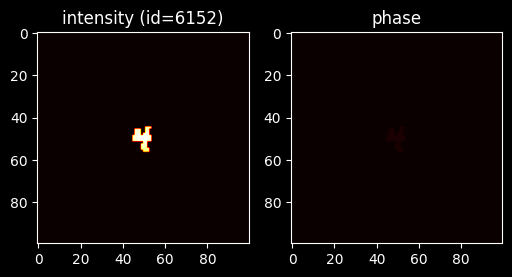

In [104]:
# plot an image
# '1' - 3214, good (1318, )
# '4' - 6152, good (1985, )
# '5' - (5134, )
# '6' - 123, good
# '8' - 128, good (1124, 8105)
# '0' - 3, good
ind_test = 6152
cmap = 'hot'

fig, axs = plt.subplots(1, 2, figsize=(2 * 3, 3))

test_wavefront, test_target = mnist_wf_test_ds[ind_test]

axs[0].set_title(f'intensity (id={ind_test})')
axs[0].imshow(test_wavefront.intensity[0], cmap=cmap)

axs[1].set_title(f'phase')
axs[1].imshow(
    test_wavefront.phase[0], cmap=cmap,
    vmin=0, vmax=2 * torch.pi
)

plt.show()

In [105]:
test_target

4

In [106]:
# propagation of the example through the trained network
setup_scheme, test_wavefronts = optical_setup_loaded.stepwise_forward(test_wavefront)

#### Amplitude profiles

-(0)-> [1. FreeSpace] -(1)-> [2. Aperture] -(2)-> [3. DiffractiveLayer] -(3)-> [4. FreeSpace] -(4)-> [5. Aperture] -(5)-> [6. DiffractiveLayer] -(6)-> [7. FreeSpace] -(7)-> [8. Aperture] -(8)-> [9. DiffractiveLayer] -(9)-> [10. FreeSpace] -(10)-> [11. Aperture] -(11)-> [12. DiffractiveLayer] -(12)-> [13. FreeSpace] -(13)-> [14. Aperture] -(14)-> [15. DiffractiveLayer] -(15)-> [16. FreeSpace] -(16)-> [17. Detector] -(17)->


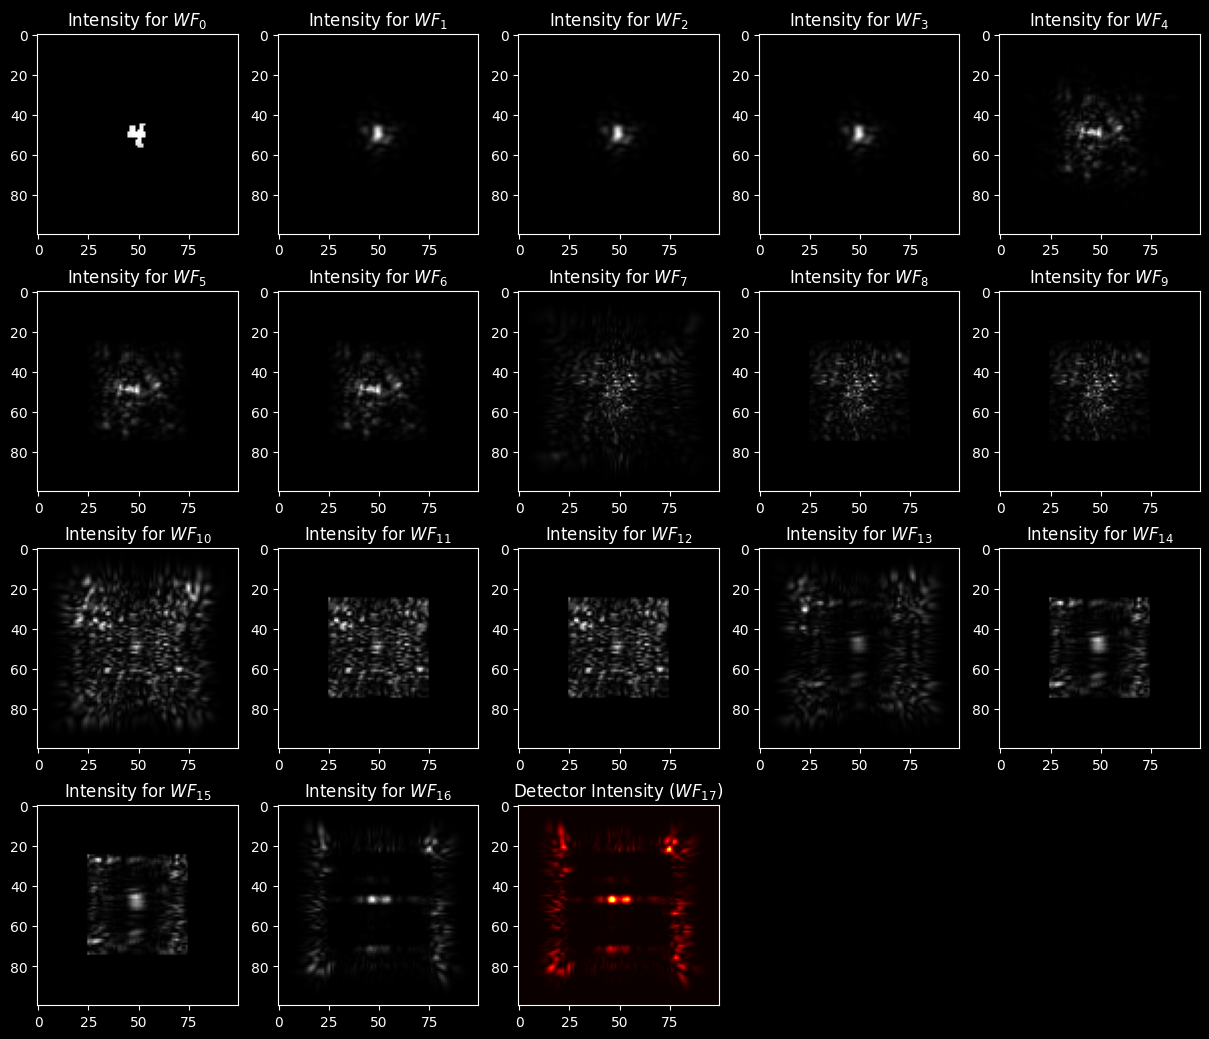

In [107]:
print(setup_scheme)  # prints propagation scheme

n_cols = 5  # number of columns to plot all wavefronts during propagation
n_rows = (len(optical_setup_loaded.net) // n_cols) + 1

to_plot = 'amp'  # <--- chose what to plot
cmap = 'grey'  # choose colormaps
detector_cmap = 'hot'

# create a figure with subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3.2))

# turn off unecessary axes
for ind_row in range(n_rows):
    for ind_col in range(n_cols):
        ax_this = axs[ind_row][ind_col]
        if ind_row * n_cols + ind_col >= len(wavefronts):
            ax_this.axis('off')

# plot wavefronts
for ind_wf, wavefront in enumerate(test_wavefronts):
    ax_this = axs[ind_wf // n_cols][ind_wf % n_cols]

    if to_plot == 'phase':
        # plot angle for each wavefront, because intensities pictures are indistinguishable from each other
        if ind_wf < len(wavefronts) - 1:
            ax_this.set_title('Phase for $WF_{' + f'{ind_wf}' + '}$')
            ax_this.imshow(
                wavefront[0].phase.detach().numpy(), cmap=cmap,
                vmin=0, vmax=2 * torch.pi
            )
        else:  # (not a wavefront!)
            ax_this.set_title('Detector phase ($WF_{' + f'{ind_wf}' + '})$')
            # Detector has no phase!

    if to_plot == 'amp':
        # plot angle for each wavefront, because intensities pictures are indistinguishable from each other
        if ind_wf < len(wavefronts) - 1:
            ax_this.set_title('Intensity for $WF_{' + f'{ind_wf}' + '}$')
            ax_this.imshow(
                wavefront[0].intensity.detach().numpy(), cmap=cmap,
                # vmin=0, vmax=max_intensity  # uncomment to make the same limits
            )
        else:  # Detector output (not a wavefront!)
            ax_this.set_title('Detector Intensity ($WF_{' + f'{ind_wf}' + '})$')
            ax_this.imshow(
                wavefront[0].detach().numpy(), cmap=detector_cmap,
                # vmin=0, vmax=max_intensity  # uncomment to make the same limits
            )
            
    # Comment: Detector output is Tensor! It has no methods of Wavefront (like .phase or .intensity)!

plt.show()

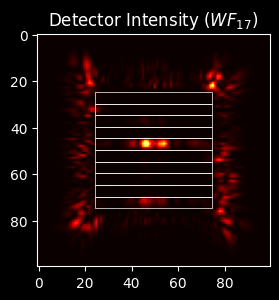

In [108]:
# create a figure with subplots
fig, ax_this = plt.subplots(1, 1, figsize=(3, 3.2))

# Detector output (not a wavefront!)
ax_this.set_title('Detector Intensity ($WF_{' + f'{ind_wf}' + '})$')
ax_this.imshow(
    test_wavefronts[-1][0].detach().numpy(), cmap='hot',
    # vmin=0, vmax=1  # uncomment to make the same limits
)

for zone in get_zones_patches(selected_detector_mask):
    # add zone's patches to the axis
    # zone_copy = copy(zone)
    ax_this.add_patch(zone)

plt.show()

#### Probabilities

In [109]:
# get probabilities of an example classification
test_probas = detector_processor.forward(test_wavefronts[-1])

for label, prob in enumerate(test_probas[0]):
    print(f'{label} : {prob * 100:.2f}%')

0 : 1.50%
1 : 3.09%
2 : 4.98%
3 : 1.15%
4 : 61.58%
5 : 2.75%
6 : 1.78%
7 : 1.47%
8 : 1.20%
9 : 20.50%
